In this notebook, we investigate an information theoretic clustering function proposed by Principe et al. for image processing and use the measure for graph clustering.

An Information Theoretic Clustering Evaluation Function
--------------------------------------------------------
Given two distributions $p(x)$ and $q(x)$, and $N$ $n$-dimensional samples ${\bf x}_i$, $i=1,\ldots,N$, we are looking for a clustering of the $N$ points into two clusters, one corresponding to $p(x)$, and one to $q(x)$. 
The following clustering evaluation function, proposed by J. Principe and his coauthors, is considered:
$$
\frac{1}{N_1N_2}\sum_{i=1}^{N_1}\sum_{j=1}^{N_2}\frac{1}{(2\pi)^{n/2}(2\sigma^2)^{n/2}}\exp\left(-\frac{1}{2}({\bf x}_i-{\bf x}_j)^T \frac{1}{2\sigma^2}({\bf x}_i-{\bf x}_j) \right)
$$
where each sum is done over one cluster, thus one cluster containing $N_1$ samples, and the other $N_2$, with $N_1+N_2=N$. The minimum of this clustering evaluation function over all possible clusterings gives an allocation of each point to its distribution.  

We define a function that performs a clustering of data points into two sets, through an exhaustive search of all possible bipartitions, using the above clustering evaluation function.

In [40]:
def Gshape(D,sigma2):
    #take an nxN array D as input, and sigma2 (which means sigma**2) is the bandwidth parameter 
    N = len(D[0]) 
    n = len(D[:,0])
    #initialization of the minimum of the evaluation function
    Gmin = 1000;   
    #tic
    t = time.time()
    #the power set of {1...N} has cardinality 2^N, but we need to test only half, and we start from 1 
    for i in range(1,2**(N-1)+1):
        binrep = np.array([int(j) for j in bin(i)[2:]])
        idx = np.hstack([np.zeros(N-len(binrep),dtype=np.int),binrep])
        #idx1 and idx2 contain all the possible choices of bipartitions
        idx1 = idx.nonzero()[0]
        idx2 = (idx-np.ones(N, dtype=np.int)).nonzero()[0]
        N1 = len(idx1)
        N2 = len(idx2)
        #initialization of the evaluation function
        G = 0;
        for k1 in range(N1):
            for k2 in range(N2):
                #some of the terms which do not influence the minimum have been ignored in the evaluation function
                x = np.matrix(D[:,idx1[k1]]-D[:,idx2[k2]])
                G = G + np.exp((-1/2)*(x*((1/(2*sigma2))*np.identity(n))*np.transpose(x)))*(1/((2*sigma2)**(n/2)))
        G = G/(N1*N2)
        if G < Gmin:
            Gmin = G
            label = idx
    #toc (this code takes ~45 mins for N=20)
    elapsed = time.time() - t
    print(elapsed)
    return label

Clustering points in the plane
----------------------------------
We generate 4 datasets that are used to test an information theoretic clustering evaluation function.

In [17]:
import numpy as np
import matplotlib.pyplot as plt
import math
import time
import random

D2 = np.array([[-0.3,-0.2,-0.1,0,0.1,0.2,0.3,-0.3,-0.2,-0.1,0,0.1,0.2,0.3],
               np.hstack([-0.2*np.ones(7),0.2*np.ones(7)])])

D3 = np.array([[-0.1, 0, 0.1,-0.2, 0.2,-0.3, 0.3,-0.1,0,0,0.1,-0.2,0.2,-0.3,0.3],
               [-0.1 ,0,-0.1,-0.2,-0.2,-0.3,-0.3, 0.3,0,0.4,0.3, 0.2,0.2, 0.1,0.1]])

D5 = np.array([-0.1+np.hstack([0.2*np.cos(np.linspace(0,math.pi,num=9)),0.2+0.2*np.cos(np.linspace(0,math.pi,num=9))]),
               np.hstack([-0.04-0.2*np.sin(np.linspace(0,math.pi,num=9)),0.04+0.2*np.sin(np.linspace(0,math.pi,num=9))])])


We try the clustering algorithm with the data D2 and $\sigma^2=0.01$.
This shape is similar to that of the paper by Principe et al., the result is the same.


In [47]:
label2 = Gshape(D2,0.01)

33.36865997314453


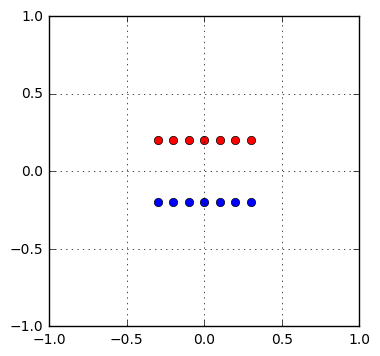

In [48]:
plt.plot(D2[0,label2.nonzero()[0]],D2[1,label2.nonzero()[0]],'ro')
plt.plot(D2[0,(label2-np.ones(len(label2))).nonzero()[0]],D2[1,(label2-np.ones(len(label2))).nonzero()[0]],'bo')
plt.axis([-1,1,-1,1])
plt.gca().set_aspect('equal', adjustable='box')
plt.grid()
plt.show()

We try the clustering algorithm with the data set D3 and $\sigma^2=0.01$.
This shape is similar to that of the paper by Principe et al., the result is the same.

In [49]:
label3 = Gshape(D3,0.01)

88.8334231376648


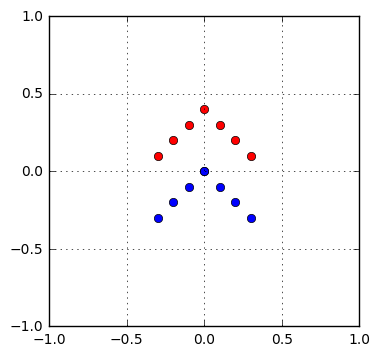

In [50]:
plt.plot(D3[0,label3.nonzero()[0]],D3[1,label3.nonzero()[0]],'ro')
plt.plot(D3[0,(label3-np.ones(len(label3))).nonzero()[0]],D3[1,(label3-np.ones(len(label3))).nonzero()[0]],'bo')
plt.axis([-1,1,-1,1])
plt.gca().set_aspect('equal', adjustable='box')
plt.grid()
plt.show()

We try the data set D4 and $\sigma^2=0.01$. This shape is inspired by that of Principe et al. but is different nevertheless. The clustering result is similar.

For the data set D5 and $\sigma^2=0.01$, the shape is inspired by that of Principe et al. but is different nevertheless. The clustering result is similar.

In [85]:
label5 = Gshape(D5,0.01)

964.0783052444458


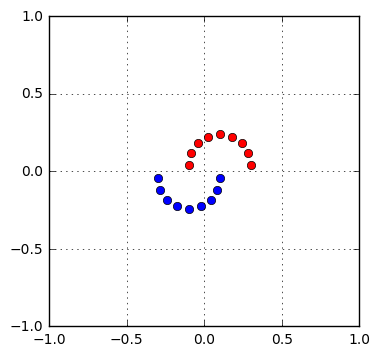

In [86]:
plt.plot(D5[0,label5.nonzero()[0]],D5[1,label5.nonzero()[0]],'ro')
plt.plot(D5[0,(label5-np.ones(len(label5))).nonzero()[0]],D5[1,(label5-np.ones(len(label5))).nonzero()[0]],'bo')
plt.axis([-1,1,-1,1])
plt.gca().set_aspect('equal', adjustable='box')
plt.grid()
plt.show()

Graph Clustering
------------------
We adapt the function Gshape to run on a graph. The distance considered is the shortest path between nodes.

In [10]:
import time
import numpy as np
import networkx as nx
import pylab as plt

def GGraphshape(G,sigma2):
    #take a networkx graph as input, and sigma2 (which means sigma**2) is the bandwidth parameter 
    #no of vertices 
    N = G.order()
    
    #for plotting the evaluation function
    Gevalpts = []
    
    #if networkx returns a dictionary of shortest paths
    paths = nx.all_pairs_shortest_path(G)
    #if networkx returns a generator for shortest paths
    #paths = list(nx.all_pairs_shortest_path(G))
    
    #the input is one-dimensional
    n=1
    #initialization of the minimum of the evaluation function
    Gmin = 1000;   
    #tic
    t = time.time()
    #the power set of {1...N} has cardinality 2^N, but we need to test only half, and we start from 1 
    for i in range(1,2**(N-1)+1):
        binrep = np.array([int(j) for j in bin(i)[2:]])
        idx = np.hstack([np.zeros(N-len(binrep),dtype=np.int),binrep])
        #idx1 and idx2 contain all the possible choices of bipartitions
        idx1 = idx.nonzero()[0]
        idx2 = (idx-np.ones(N, dtype=np.int)).nonzero()[0]
        N1 = len(idx1)
        N2 = len(idx2)
        #initialization of the evaluation function
        Geval = 0;
        for k1 in range(N1):
            for k2 in range(N2):
                #some of the terms which do not influence the minimum have been ignored in the evaluation function
                ##if networkx returns a dictionary of shortest paths
                x = np.matrix(len(paths[idx1[k1]][idx2[k2]]))
                ##if networkx returns a generator of shortest paths
                #x = np.matrix(len(paths[idx1[k1]][1][idx2[k2]]))
                Geval = Geval + np.exp((-1/2)*(x*((1/(2*sigma2))*np.identity(n))*np.transpose(x)))*(1/((2*sigma2)**(n/2)))
        Geval = Geval/(N1*N2)
        
        #for plotting the evaluation function
        Gevalpts.append(Geval[0,0])
        
        if Geval < Gmin:
            Gmin = Geval
            label = idx
    #toc (this code takes ~45 mins for N=20)
    elapsed = time.time() - t
    print('time in secs',elapsed)
    
    #for plotting the evaluation function
    plt.plot(Gevalpts)
    #plt.plot(sorted(Gevalpts))
    plt.grid()
    plt.show()
    
    return list(label)

We try the function on a small graph, the plot shows the value of the evaluation function as a function of the clustering, in order of attempt.

time in secs 0.11957287788391113


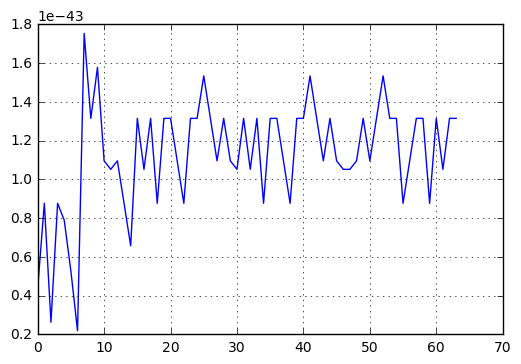

[0, 0, 0, 0, 1, 1, 1]


In [9]:
L43 = nx.lollipop_graph(4,3)
labelL43 = GGraphshape(L43,0.01)
print(labelL43)

The values of the evaluation function are sorted in this plot.

time in secs 0.10030460357666016


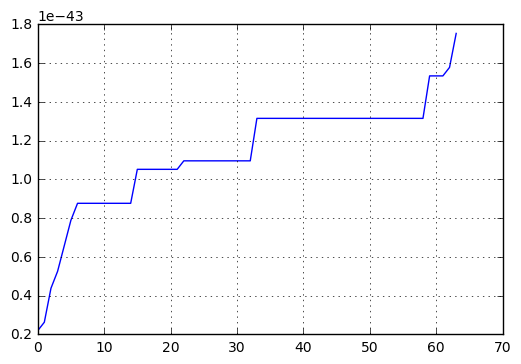

[0, 0, 0, 0, 1, 1, 1]


In [11]:
L43 = nx.lollipop_graph(4,3)
labelL43 = GGraphshape(L43,0.01)
print(labelL43)

This shows the result of the clustering.

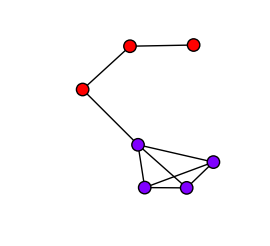

In [69]:
val_map = {}
for k in range(0,L43.order()):
    val_map[k] = labelL43[k]

values = [val_map.get(node, 0.25) for node in L43.nodes()]

#this fixes the size of the figure
plt.figure(1,figsize=(2,2)) 
nx.draw(L43, cmap=plt.get_cmap('rainbow'), node_color=values, node_size = 80)
plt.show()

We try another graph example, the Barbell graph.

In [33]:
B42 = nx.barbell_graph(4,2)
labelB42 = GGraphshape(B42,0.01)

1.1308205127716064


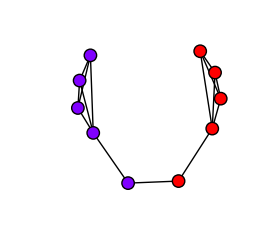

In [74]:
val_map = {}
for k in range(0,B42.order()):
    val_map[k] = labelB42[k]

values = [val_map.get(node, 0.25) for node in B42.nodes()]

#this fixes the size of the figure
plt.figure(1,figsize=(2,2)) 
nx.draw(B42, cmap=plt.get_cmap('rainbow'), node_color=values, node_size = 80)
plt.show()

We try another graph example, the ladder graph.

In [75]:
L6 = nx.ladder_graph(6)
labelL6 = GGraphshape(L6,0.01)

6.715381860733032


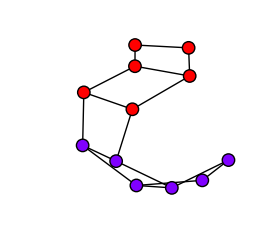

In [77]:
val_map = {}
for k in range(0,L6.order()):
    val_map[k] = labelL6[k]

values = [val_map.get(node, 0) for node in L6.nodes()]

#this fixes the size of the figure
plt.figure(1,figsize=(2,2)) 
nx.draw(L6, cmap=plt.get_cmap('rainbow'), node_color=values, node_size = 80)
plt.show()

Hierarchical Clustering
--------------------------

We try to use hierarchial clustering, since doing exhaustive search of all the labels is not possible apart for toy examples.

For that, we compute a distance matrix, and then feed it to the python function linkage.

In [15]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.spatial.distance as ssd
from scipy.cluster.hierarchy import linkage, dendrogram

def Gdist(D,sigma2):
    #take an nxN array D as input, and sigma2 (which means sigma**2) is the bandwidth parameter 
    #outputs a distance matrix
    N = len(D[0]) 
    n = len(D[:,0])
    dist = np.zeros((N,N))
    for k1 in range(N):
        #we want 0 on the diagonal since distance from a point to itself is 0
        for k2 in [i for i in range(N) if not(i == k1)]:
            #some of the terms which do not influence the minimum have been ignored in the evaluation function
            x = np.matrix(D[:,k1]-D[:,k2])
            dist[k1,k2]=np.exp((-1/2)*(x*((1/(2*sigma2))*np.identity(n))*np.transpose(x)))*(1/((2*sigma2)**(n/2)))   
    return dist

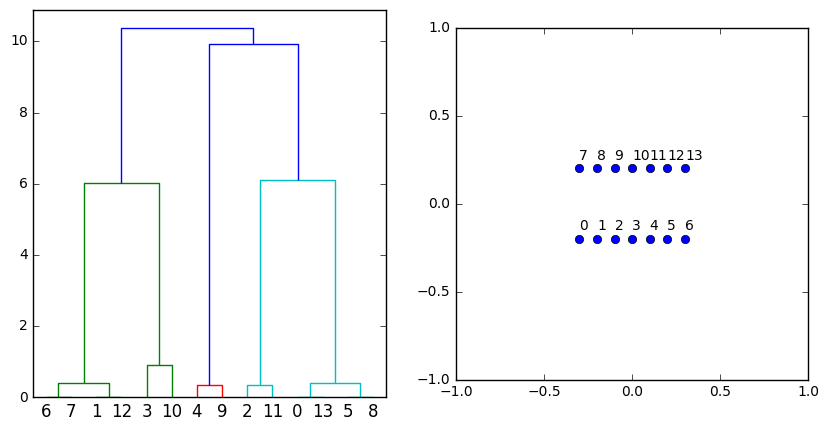

In [71]:
# convert the NxN distance matrix form into a condensed nC2 array suitabled as input to linkage 
HC = linkage(ssd.squareform(Gdist(D2,0.01)), 'average')

plt.figure(1,figsize=(10,5))
plt.subplot(121)
dn = dendrogram(HC)
plt.subplot(122)
num_rows, num_cols = D2.shape
for i in range(0,num_cols):
    #draw and annotate nodes
    plt.plot(D2[0,i],D2[1,i],'ob')
    plt.annotate(i,(D2[0,i],D2[1,i]+0.05))
plt.axis([-1,1,-1,1])
plt.gca().set_aspect('equal', adjustable='box')

plt.show()

We observe that it does not work, which is normal in fact, since the hierarchical clustering starts by choosing two points which are far apart (the evaluation function we consider looks for two clusters which are far apart) as being in the same cluster.

Just out of curiosity, we redo the hierarchical by using the inverse of the evaluation function, it gives more of a clustering, but not what is wanted.

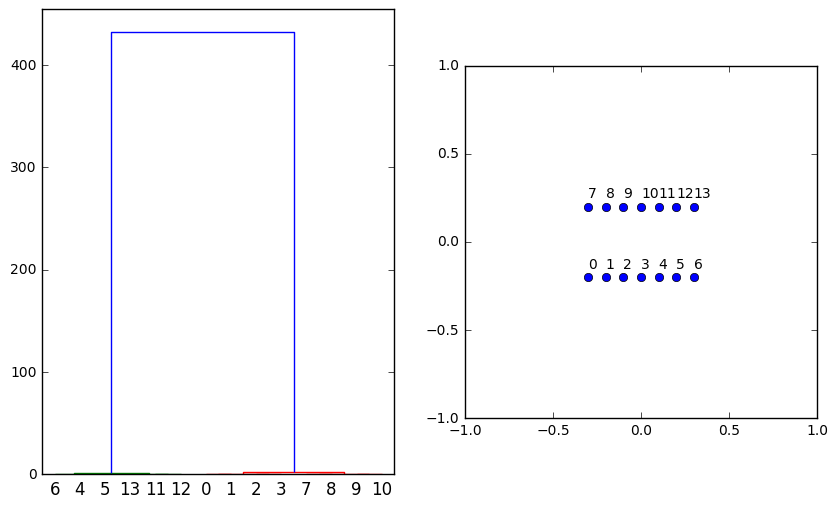

In [21]:
distM = Gdist(D2,0.01)
np.fill_diagonal(distM,1)
distinvM = 1./distM
np.fill_diagonal(distinvM,0)
# convert the NxN distance matrix form into a condensed nC2 array suitabled as input to linkage 
HC = linkage(ssd.squareform(distinvM), 'average')

plt.figure(1,figsize=(10,6))
plt.subplot(121)
dn = dendrogram(HC)
plt.subplot(122)
num_rows, num_cols = D2.shape
for i in range(0,num_cols):
    #draw and annotate nodes
    plt.plot(D2[0,i],D2[1,i],'ob')
    plt.annotate(i,(D2[0,i],D2[1,i]+0.05))
plt.axis([-1,1,-1,1])
plt.gca().set_aspect('equal', adjustable='box')

plt.show()

We obviously observe the same problem using the graph clustering.

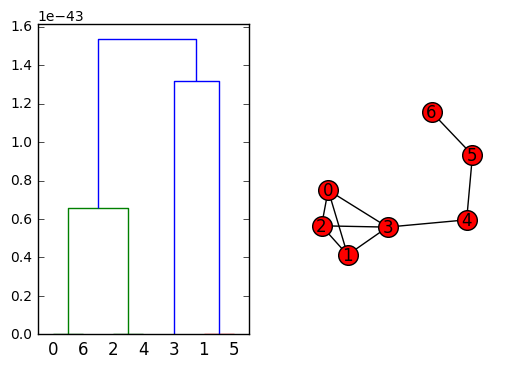

In [29]:
# convert the NxN distance matrix form into a condensed nC2 array suitabled as input to linkage 
HC = linkage(ssd.squareform(GGraphdist(L43,0.01)), 'average')

plt.figure(1,figsize=(6,4))
plt.subplot(121)
dn = dendrogram(HC)
plt.subplot(122)
pos = nx.spring_layout(L43)
#this draws the nodes
nx.draw_networkx_nodes(L43, pos, node_color = 'red', node_size = 200)
#this draws the labels of the nodes
nx.draw_networkx_labels(L43,pos)
#this draws the edges
nx.draw_networkx_edges(L43, pos, edge_color='black', arrows=True)
#this removes the axes from the display
plt.axis('off')
plt.gca().set_aspect('equal', adjustable='box')

Splt.show()

Simulated Annealing
---------------------

This just plots a sum of exponentials versus a log sum of exponentials to see the log concavity.

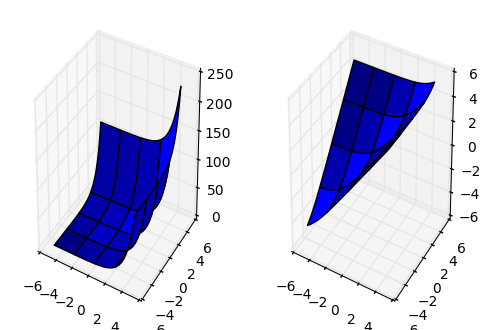

In [40]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure()
# set up the axes for the first plot
ax = fig.add_subplot(121, projection='3d')

X = np.arange(-5, 5, 0.25)
Y = np.arange(-5, 5, 0.25)
X, Y = np.meshgrid(X, Y)
Z = np.exp(X) + np.exp(Y)

surf = ax.plot_surface(X, Y, Z)

# set up the axes for the second plot
ax = fig.add_subplot(122, projection='3d')

X = np.arange(-5, 5, 0.25)
Y = np.arange(-5, 5, 0.25)
X, Y = np.meshgrid(X, Y)
Z = np.log(np.exp(X) + np.exp(Y))

surf = ax.plot_surface(X, Y, Z)
plt.show()

We implement a simulated annealing search to replace the exhaustive search.


In [137]:
import time
import numpy as np
import networkx as nx
import pylab as plt

def SAGGraph(G,sigma2,iter_max,beta):
    #take a networkx graph as input, and sigma2 (which means sigma**2) is the bandwidth parameter 
    #iter_max is the maximum number of iterations
    #beta decides the probability of transition if the labelling is improving
    #no of vertices 
    N = G.order()
    
    #for plotting the evaluation function
    Gevalpts = []
    
    #if networkx returns a dictionary of shortest paths
    paths = nx.all_pairs_shortest_path(G)
    #if networkx returns a generator for shortest paths
    #paths = list(nx.all_pairs_shortest_path(G))
    
    #the input is one-dimensional
    n=1
    
    def EF(cur_label):
        #idx1 and idx2 contain the bipartition
        idx1 = cur_label.nonzero()[0]
        idx2 = (cur_label-np.ones(N, dtype=np.int)).nonzero()[0]
        N1 = len(idx1)
        N2 = len(idx2)
        #initialization of the evaluation function
        Geval = 0;
        for k1 in range(N1):
            for k2 in range(N2):
                #some of the terms which do not influence the minimum have been ignored in the evaluation function
                ##if networkx returns a dictionary of shortest paths
                x = np.matrix(len(paths[idx1[k1]][idx2[k2]]))
                ##if networkx returns a generator of shortest paths
                #x = np.matrix(len(paths[idx1[k1]][1][idx2[k2]]))
                Geval = Geval + np.exp((-1/2)*(x*((1/(2*sigma2))*np.identity(n))*np.transpose(x)))*(1/((2*sigma2)**(n/2)))
        #Geval is currently a one by one matrix
        return Geval[0,0]/(N1*N2)
    
    #initial labelling
    label = np.random.randint(2,size=N)
    #initialization of the minimum of the evaluation function
    Gmin = EF(label)
    Gevalpts.append(Gmin)
    
    #tic
    t = time.time()
    for attmpt in range(iter_max):
        #change one vertex uniformly at random
        rdidx = np.random.randint(N)
        #lab in [0,1] for 2 clusters
        label[rdidx] = [lab for lab in [0,1] if not(lab==label[rdidx])][0]
        #for small graphs, there is a likelihood to reach a single clustering
        #if that happens, change again a label
        if not np.any(label) or not np.any(label-np.ones(N)):
            rdidx = np.random.randint(N)
            label[rdidx] = [lab for lab in [0,1] if not(lab==label[rdidx])][0]  
        #recompute the evaluation function
        Delta = EF(label)-Gmin
        
        #if Delta <=0, we accept this change and continue
        if Delta <= 0:
            Gmin = EF(label)
            #for plotting the evaluation function
            Gevalpts.append(Gmin)    
        else:
            #if Delta > 0, we still accept the change with a small probability
            if np.random.random() < np.exp(-beta*Delta):
                #with high probability we don't accept the change and revert back
                #lab in [0,1] for 2 clusters
                label[rdidx] = [lab for lab in [0,1] if not(lab==label[rdidx])][0]
            
    #toc 
    elapsed = time.time() - t
    print('time in secs',elapsed)
    print('evaluation function',Gevalpts[-1])
    
    #for plotting the evaluation function
    plt.plot(Gevalpts)
    plt.grid()
    plt.show()
    
    return list(label)

We try the simulated annealing on the lollipop graph, by setting $\beta=0$, we always reject a labelling that worsens the evaluating function.

time in secs 0.052124977111816406
evaluation function 2.19207579098e-44


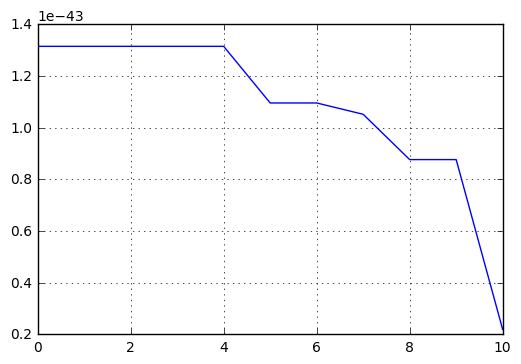

[0, 0, 0, 0, 1, 1, 1]


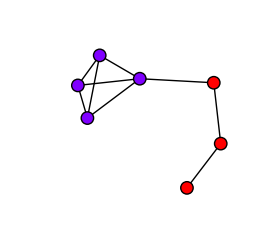

In [138]:
L43 = nx.lollipop_graph(4,3)
labelL43 = SAGGraph(L43,0.01,20,0)
print(labelL43)
val_map = {}
for k in range(0,L43.order()):
    val_map[k] = labelL43[k]

values = [val_map.get(node, 0) for node in L43.nodes()]

#this fixes the size of the figure
plt.figure(1,figsize=(2,2)) 
nx.draw(L43, cmap=plt.get_cmap('rainbow'), node_color=values, node_size = 80)
plt.show()

We try out the karate club graph.

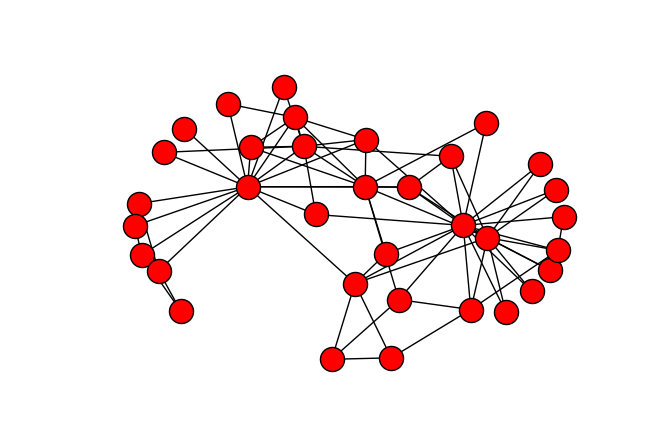

In [102]:
Kcg = nx.karate_club_graph()
nx.draw(Kcg)
plt.show()

We observe that the first node has many neighbours.

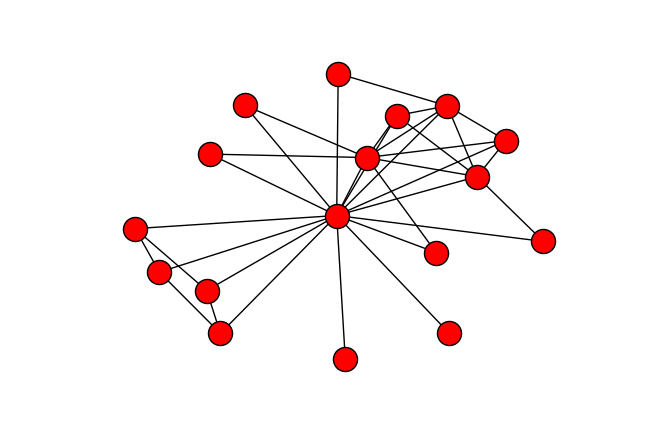

In [82]:
neighb0 = list(nx.neighbors(Kcg,0))
neighb0.append(0)
Kcg0 = Kcg.subgraph(neighb0)
nx.draw(Kcg0)
plt.show()

We try simulated annealing, still with $\beta=0$.

time in secs 2.957570791244507
evaluation function 1.22129936926e-44


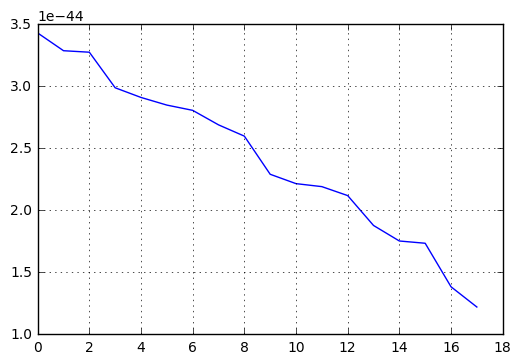

In [114]:
labelkcg = SAGGraph(Kcg,0.01,100,0.9)

[1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0]


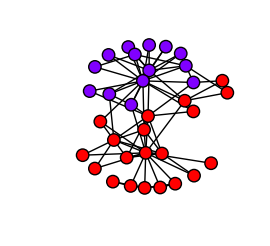

In [115]:
print(labelkcg)
val_map = {}
for k in range(0,Kcg.order()):
    val_map[k] = labelkcg[k]

values = [val_map.get(node, 0) for node in Kcg.nodes()]

#this fixes the size of the figure
plt.figure(1,figsize=(2,2)) 
nx.draw(Kcg, cmap=plt.get_cmap('rainbow'), node_color=values, node_size = 80)
plt.show()

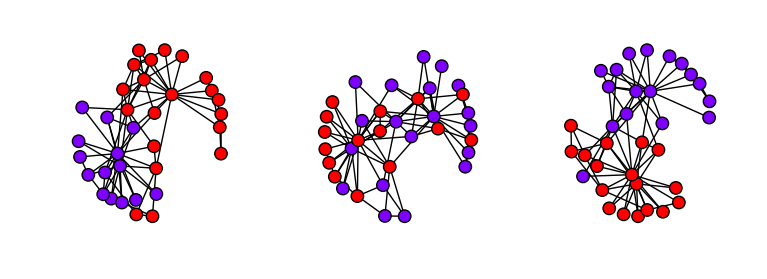

In [118]:
lab1 = labelkcg
lab2 = [0,1,0,1,0,0,0,0,1,0,0,0,1,0,0,1,0,1,1,0,1,0,1,1,0,0,1,0,0,1,1,1,0,1]
lab3 = [0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,1,0,0,1,0,1,0,1,1,1,1,1,1,1,1,1,1,1,1]

#this fixes the size of the figure
plt.figure(1,figsize=(9,3)) 
#first subplot
plt.subplot(131)
val_map = {}
for k in range(0,Kcg.order()):
    val_map[k] = lab1[k]

values = [val_map.get(node, 0) for node in Kcg.nodes()]
nx.draw(Kcg, cmap=plt.get_cmap('rainbow'), node_color=values, node_size = 80)

#second subplot
plt.subplot(132)
val_map = {}
for k in range(0,Kcg.order()):
    val_map[k] = lab2[k]

values = [val_map.get(node, 0) for node in Kcg.nodes()]
nx.draw(Kcg, cmap=plt.get_cmap('rainbow'), node_color=values, node_size = 80)

#third subplot
plt.subplot(133)
val_map = {}
for k in range(0,Kcg.order()):
    val_map[k] = lab3[k]

values = [val_map.get(node, 0) for node in Kcg.nodes()]
nx.draw(Kcg, cmap=plt.get_cmap('rainbow'), node_color=values, node_size = 80)

plt.show()

We adapt the algorithm to support more than 2 clusters.

In [1]:
import time
import numpy as np
import networkx as nx
import pylab as plt

def SAGGraphc(G,sigma2,iter_max,beta,nb_cluster):
    #take a networkx graph as input, and sigma2 (which means sigma**2) is the bandwidth parameter 
    #iter_max is the maximum number of iterations
    #beta decides the probability of transition if the labelling is improving
    #nb_cluster is the number of clusters
    #no of vertices 
    N = G.order()
    
    #for plotting the evaluation function
    Gevalpts = []
    
    #if networkx returns a dictionary of shortest paths
    paths = nx.all_pairs_shortest_path(G)
    #if networkx returns a generator for shortest paths
    #paths = list(nx.all_pairs_shortest_path(G))
    print('shortest paths computed')
    
    #the input is one-dimensional
    n=1
    
    def EF(cur_label):
        #count how many elements are in each cluster
        #if count(c)=0, then one label is actually not present but we continue
        cluster_sizes = np.array([list(cur_label).count(c) for c in range(nb_cluster) if list(cur_label).count(c)>0])        
        #initialization of the evaluation function
        Geval = 0;
        for k1 in range(N):
            #check that k2 is in a different cluster from k1
            for k2 in [idx for idx in range(N) if not(cur_label[idx]==cur_label[k1])]:
                #some of the terms which do not influence the minimum have been ignored in the evaluation function
                ##if networkx returns a dictionary of shortest paths
                x = np.matrix(len(paths[k1][k2]))
                ##if networkx returns a generator of shortest paths
                #x = np.matrix(len(paths[k1][1][k2]))
                Geval = Geval + np.exp((-1/2)*(x*((1/(2*sigma2))*np.identity(n))*np.transpose(x)))*(1/((2*sigma2)**(n/2)))
        #Geval is currently a one by one matrix  
        #log function can be used for computations
        return np.log(Geval[0,0]/np.prod(cluster_sizes))
    
    #initial labelling
    label = np.random.randint(nb_cluster,size=N)
    #label = np.array([0,0,0,0,1,1,1,1,2,2,2,2,3,3,3,3,0,1,2,3,3])
    #initialization of the minimum of the evaluation function
    Gmin = EF(label)
    Gevalpts.append(Gmin)
    
    #tic
    t = time.time()
    for attmpt in range(iter_max):
        #print('attempt no',attmpt)
        #change one vertex uniformly at random
        rdidx = np.random.randint(N)
        old_label = label[rdidx]
        new_label = np.random.choice([lab for lab in range(nb_cluster) if not(lab==old_label)]) 
        label[rdidx] = new_label     
        #for small graphs, there is a likelihood to reach a single clustering
        #if that happens, change again a label, this is written for two clusters
        if not np.any(label) or not np.any(label-np.ones(N)):
            rdidx = np.random.randint(N)
            old_label = label[rdidx]
            new_label = np.random.choice([lab for lab in range(nb_cluster) if not(lab==old_label)]) 
            label[rdidx] = new_label 
        #recompute the evaluation function
        Delta = EF(label)-Gmin
        
        #if Delta <=0, we accept this change and continue
        if Delta <= 0:
            Gmin = EF(label)
            #for plotting the evaluation function
            Gevalpts.append(Gmin)    
        else:
            #if Delta > 0, we still accept the change with a small probability
            if np.random.random() < np.exp(-beta*Delta):
                #with high probability we don't accept the change and revert back
                label[rdidx] = old_label
            
    #toc 
    elapsed = time.time() - t
    print('time in secs',elapsed)
    print('evaluation function',Gevalpts[-1])
    
    #for plotting the evaluation function
    plt.plot(Gevalpts)
    plt.grid()
    plt.show()
    
    return list(label)

We test the new algorithm on a lollipop graph.

shortest paths computed
time in secs 0.09290623664855957
evaluation function -99.8357479665


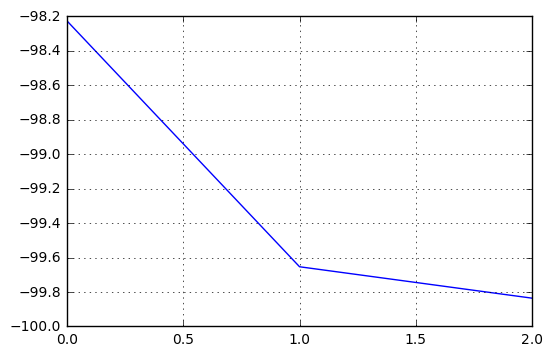

[0, 0, 0, 0, 1, 1, 1]


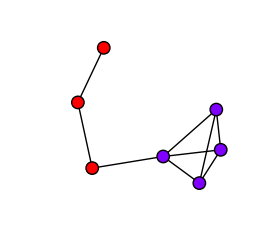

In [6]:
L43 = nx.lollipop_graph(4,3)
labelL43 = SAGGraphc(L43,0.01,20,0,2)
print(labelL43)
val_map = {}
for k in range(0,L43.order()):
    val_map[k] = labelL43[k]

values = [val_map.get(node, 0) for node in L43.nodes()]

#this fixes the size of the figure
plt.figure(1,figsize=(2,2)) 
nx.draw(L43, cmap=plt.get_cmap('rainbow'), node_color=values, node_size = 80)
plt.show()

We create a graph by gluing several lollipop graphs around a star graph.

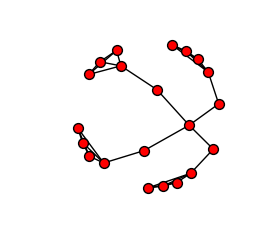

In [8]:
from itertools import combinations

G4k3=nx.Graph()
#empty edges
E = []
#create edges for a complete graph on nv=3 vertices
nv = 4
Ek = [list(e) for e in combinations(range(nv),2)]
#creates 4 complete graphs
for j in range(4):
    E.extend([[e[0]+nv*j,e[1]+nv*j] for e in Ek])
    #E.append([4*nv,nv*j])
    E.append([nv*j,4*nv+j])
    E.append([4*nv+j,4*(nv+1)])
G4k3.add_edges_from(E)

plt.figure(1,figsize=(2,2)) 
nx.draw(G4k3, node_size=50)
plt.show()

We test the algorithm on this new graph wih 4 clusters.

shortest paths computed
time in secs 3.2159929275512695
evaluation function -102.202871581


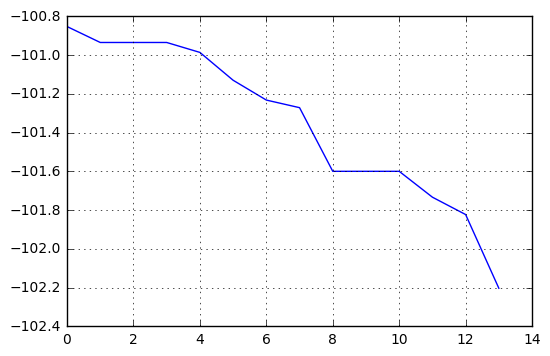

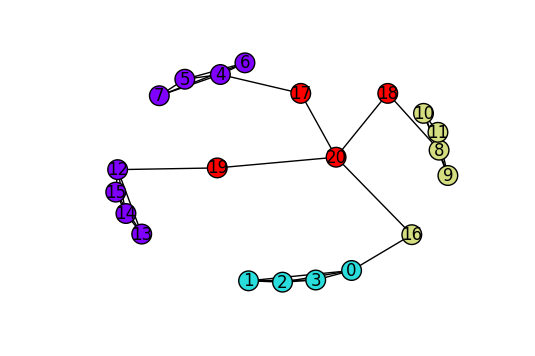

In [11]:
labelG4k3 = SAGGraphc(G4k3,0.01,100,0,4)
val_map = {}
for k in range(0,G4k3.order()):
    val_map[k] = labelG4k3[k]

values = [val_map.get(node, 0) for node in G4k3.nodes()]

#this fixes the size of the figure
#plt.figure(1,figsize=(2,2)) 
pos = nx.spring_layout(G4k3)
nx.draw_networkx_labels(G4k3,pos)
nx.draw(G4k3, pos, cmap=plt.get_cmap('rainbow'), node_color=values, node_size = 200)
plt.show()

We try a few runs, and pick the best solution.

In [33]:
labs = []
for cnt in range(0,5):
    labs.append(SAGGraphc(G4k3,0.01,150,0,4))
    print(labs[-1]) 

shortest paths computed
time in secs 4.769768476486206
evaluation function -101.915189508
[3, 3, 3, 3, 0, 0, 0, 0, 1, 1, 1, 1, 2, 0, 0, 0, 3, 2, 3, 2, 2]
shortest paths computed
time in secs 4.760714292526245
evaluation function -102.110162183
[2, 2, 2, 2, 1, 1, 1, 1, 3, 3, 3, 0, 0, 0, 0, 0, 2, 3, 3, 3, 3]
shortest paths computed
time in secs 5.088750839233398
evaluation function -101.82248011
[3, 1, 3, 3, 0, 0, 0, 0, 2, 2, 2, 2, 1, 1, 1, 1, 3, 2, 0, 0, 0]
shortest paths computed
time in secs 5.329617977142334
evaluation function -102.13833306
[1, 1, 2, 1, 3, 3, 3, 3, 0, 0, 0, 0, 2, 2, 2, 2, 1, 3, 0, 2, 0]
shortest paths computed
time in secs 4.807872295379639
evaluation function -102.426015132
[0, 0, 0, 0, 0, 0, 0, 0, 3, 3, 3, 3, 2, 2, 2, 2, 1, 1, 3, 1, 1]


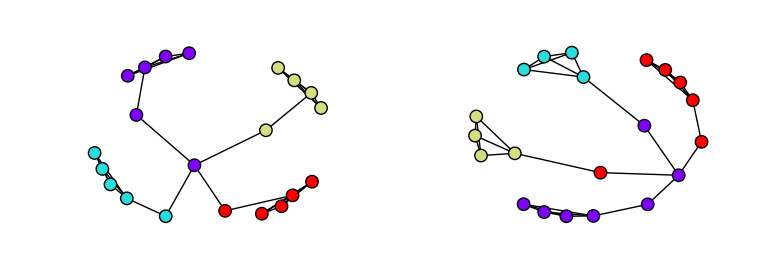

In [27]:
#-102.872302235
#[0, 0, 0, 0, 2, 2, 2, 2, 1, 1, 1, 1, 3, 3, 3, 3, 0, 2, 1, 3, 0]
#-102.713697204
#[0, 0, 0, 0, 1, 1, 1, 1, 2, 2, 2, 2, 3, 3, 3, 3, 0, 3, 3, 3, 3]

lab1 = [0, 0, 0, 0, 2, 2, 2, 2, 1, 1, 1, 1, 3, 3, 3, 3, 0, 2, 1, 3, 0]
lab2 = [0, 0, 0, 0, 2, 2, 2, 2, 3, 3, 3, 3, 1, 1, 1, 1, 0, 3, 3, 0, 0]

#this fixes the size of the figure
plt.figure(1,figsize=(9,3)) 
#first subplot
plt.subplot(121)
val_map = {}
for k in range(0,G4k3.order()):
    val_map[k] = lab1[k]

values = [val_map.get(node, 0) for node in G4k3.nodes()]
nx.draw(G4k3, cmap=plt.get_cmap('rainbow'), node_color=values, node_size = 80)

#second subplot
plt.subplot(122)
val_map = {}
for k in range(0,G4k3.order()):
    val_map[k] = lab2[k]

values = [val_map.get(node, 0) for node in G4k3.nodes()]
nx.draw(G4k3, cmap=plt.get_cmap('rainbow'), node_color=values, node_size = 80)

plt.show()

We try on a small subgraph of the Bitcoin network.

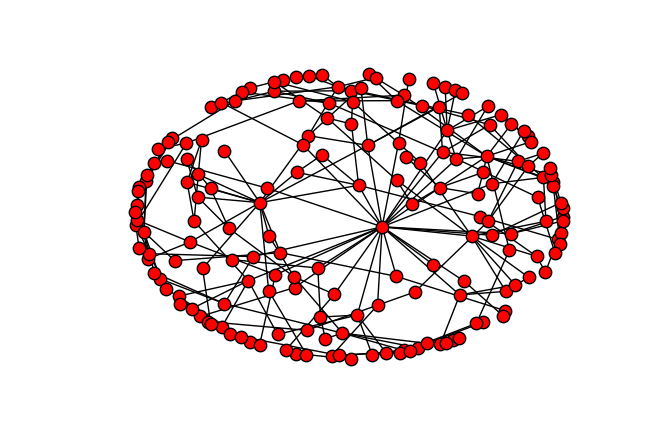

In [3]:
fh=open("/home/frederique//Desktop/Bitcoin/isita-clust18/subgraphsmall.txt", 'rb')
G2h = nx.read_edgelist(fh,delimiter=',',create_using=nx.Graph())
G2h.order()
G2h = nx.convert_node_labels_to_integers(G2h, first_label=0, ordering='default')
nx.draw(G2h,node_size=80)
plt.show()

shortest paths computed
time in secs 620.7949154376984
evaluation function -107.64873303


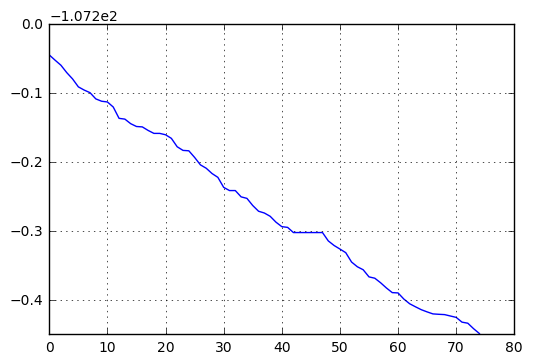

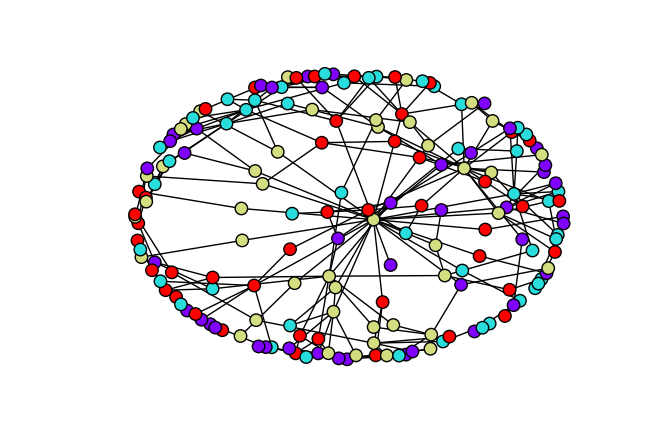

In [46]:
labelG2h = SAGGraphc(G2h,0.01,200,0,4)
val_map = {}
for k in range(0,G2h.order()):
    val_map[k] = labelG2h[k]

values = [val_map.get(node, 0) for node in G2h.nodes()]

#this fixes the size of the figure
#plt.figure(1,figsize=(2,2)) 
pos = nx.spring_layout(G2h)
nx.draw(G2h, pos, cmap=plt.get_cmap('rainbow'), node_color=values, node_size = 80)
plt.show()

shortest paths computed
time in secs 896.9385995864868
evaluation function -107.736261069


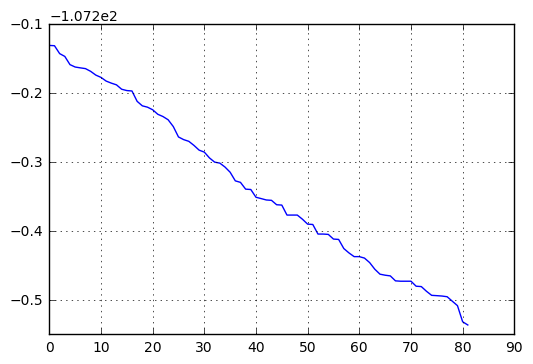

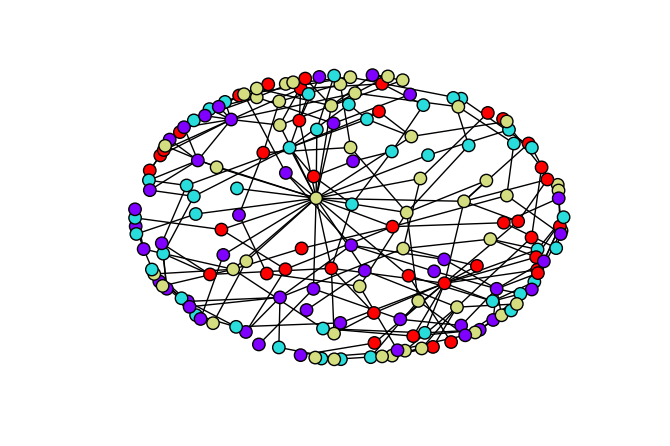

In [56]:
labelG2h = SAGGraphc(G2h,0.01,300,0,4)
val_map = {}
for k in range(0,G2h.order()):
    val_map[k] = labelG2h[k]

values = [val_map.get(node, 0) for node in G2h.nodes()]

#this fixes the size of the figure
#plt.figure(1,figsize=(2,2)) 
pos = nx.spring_layout(G2h)
nx.draw(G2h, pos, cmap=plt.get_cmap('rainbow'), node_color=values, node_size = 80)
plt.show()

In [62]:
print(labelG2h)

[0, 0, 0, 0, 3, 3, 2, 2, 1, 1, 1, 1, 0, 2, 3, 1, 1, 3, 1, 0, 3, 0, 3, 3, 1, 1, 0, 0, 2, 3, 0, 0, 2, 2, 1, 3, 0, 0, 1, 3, 1, 0, 1, 2, 0, 0, 3, 3, 2, 0, 3, 3, 3, 2, 1, 1, 2, 2, 1, 1, 1, 2, 3, 0, 3, 2, 2, 0, 2, 3, 0, 3, 1, 3, 2, 3, 3, 1, 1, 0, 1, 1, 3, 2, 2, 1, 3, 1, 3, 2, 1, 2, 3, 2, 3, 1, 2, 3, 3, 2, 1, 1, 0, 0, 2, 2, 3, 2, 3, 0, 0, 0, 3, 0, 0, 1, 2, 2, 3, 2, 2, 2, 0, 1, 2, 2, 0, 3, 1, 3, 2, 3, 0, 2, 0, 3, 2, 0, 1, 1, 1, 2, 0, 2, 3, 0, 0, 2, 2, 0, 2, 3, 1, 0, 1, 2, 1, 0, 2, 1, 0, 0, 1, 1, 2, 1, 0, 0, 1, 0, 1, 3, 2, 2, 0, 2, 2, 0]


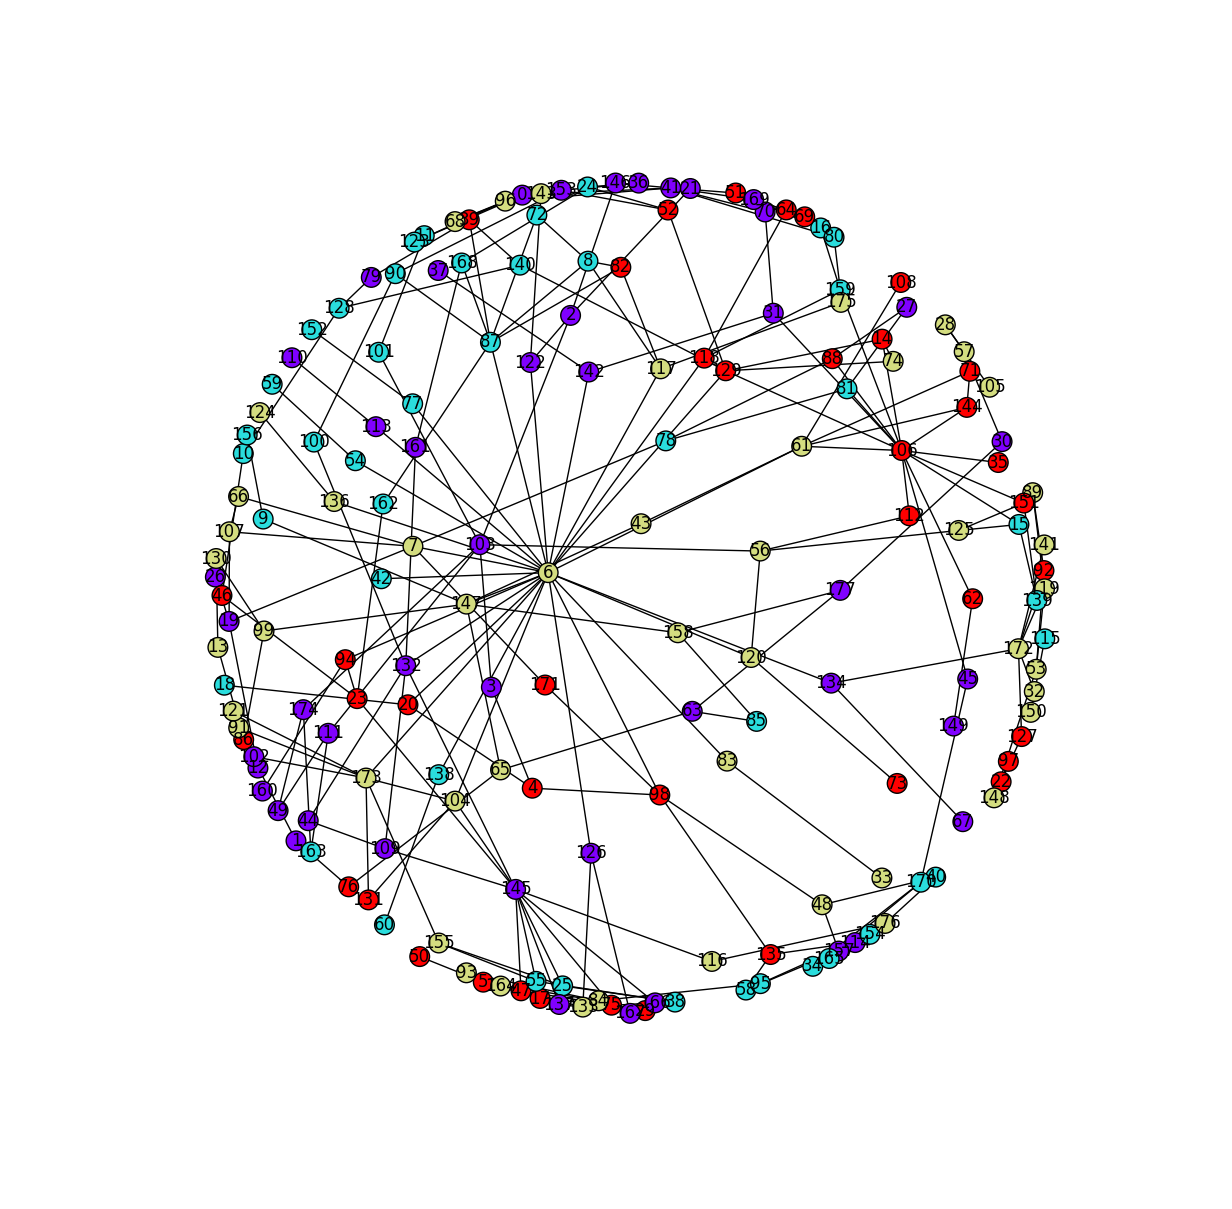

In [57]:
plt.figure(1,figsize=(15,15)) 
pos = nx.spring_layout(G2h)
nx.draw_networkx_labels(G2h,pos)
nx.draw(G2h, pos, cmap=plt.get_cmap('rainbow'), node_color=values, node_size = 200)
plt.show()

The way networkX shows graphs is very nice, but this graph should still be plotted with Gephi for a better visualization of the clusters.